## Predict employee attrition

In [12]:
!pip install xgboost
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

## Read train and test data

In [13]:
employee_data = pd.read_csv("employee_data.csv", header=0, sep=',')
train_work = pd.read_csv("train_work.csv", header=0, sep=',')
train_attrition = pd.read_csv("train_attrition.csv", header=0, sep=',')

test_work = pd.read_csv("test_work.csv", header=0, sep=',')
test_attrition = pd.read_csv("test_attrition.csv", header=0, sep=',')

In [14]:
#Merging the rows of Train work employee wise
train_work_sum = train_work.groupby('EmployeeID').sum().reset_index()
train_work_sum.shape
train_work_sum.head()

,EmployeeID,TotalWorkingHours,Billable_Hours,Hours_off_Duty,Touring_Hours,NoOfProjects,ActualTimeSpent
0,emp-1,3424.0,2462.0,408.0,2462.0,42,2849
1,emp-10,2006.0,1274.0,328.0,691.0,13,616
2,emp-100,3607.0,3275.0,224.0,3235.0,23,3388
3,emp-101,4109.5,2759.5,192.0,0.0,18,1953
4,emp-102,3790.0,2720.5,344.0,1861.0,20,2254


In [15]:
# merging employee data and train work
merged_train_data = pd.merge(train_work_sum,employee_data, on='EmployeeID', how='left')
merged_train_data.shape

(245, 11)

In [16]:
# merging with train attrition
final_train_data = pd.merge(merged_train_data, train_attrition, on='EmployeeID', how='left')
final_train_data.shape
final_train_data.head()

,EmployeeID,TotalWorkingHours,Billable_Hours,Hours_off_Duty,Touring_Hours,NoOfProjects,ActualTimeSpent,Job_History,Joining_Date,Designation,Sex,Left_Company
0,emp-1,3424.0,2462.0,408.0,2462.0,42,2849,"Worked at Company - 639 , Company - 212 , Comp...",2011_01,MD,1,0.0
1,emp-10,2006.0,1274.0,328.0,691.0,13,616,"Worked at Company - 816 , Company - 724 , Comp...",2006_02,VP,0,1.0
2,emp-100,3607.0,3275.0,224.0,3235.0,23,3388,"Worked at Company - 562 , Company - 319",2011_12,Senior,1,0.0
3,emp-101,4109.5,2759.5,192.0,0.0,18,1953,"Worked at Company - 212 , Company - 668 , Comp...",2012_01,Senior,1,0.0
4,emp-102,3790.0,2720.5,344.0,1861.0,20,2254,Worked at Company - 234,2011_12,Senior,1,0.0


In [17]:
# merging test work employee wise
test_work_sum = test_work.groupby('EmployeeID').sum().reset_index()
test_work_sum.shape
#test_work_sum.head()

(51, 7)

In [18]:
# merging test work with employee sum
final_test_data = pd.merge(test_work_sum,employee_data, on='EmployeeID', how='left')
final_test_data.shape
final_test_data.head()

,EmployeeID,TotalWorkingHours,Billable_Hours,Hours_off_Duty,Touring_Hours,NoOfProjects,ActualTimeSpent,Job_History,Joining_Date,Designation,Sex
0,emp-106,3309.5,2352.0,298.0,2.0,18,1736,"Worked at Company - 510 , Company - 658 , Comp...",2012_01,Senior,0
1,emp-112,3178.5,2610.0,292.0,325.0,21,1708,"Worked at Company - 42 , Company - 432 , Compa...",2012_02,VP,1
2,emp-114,3072.5,1618.7,264.0,1104.0,25,882,"Worked at Company - 99 , Company - 88 , Compan...",2012_02,EVP,1
3,emp-118,2400.0,2008.0,146.0,728.0,18,1526,"Worked at Company - 554 , Company - 304",2012_04,EVP,1
4,emp-12,4491.0,2653.0,601.0,799.0,31,1883,"Worked at Company - 548 , Company - 405",2006_09,VP,1


## Data pre-processing

In [19]:
# drop unwanted columns
final_train_data.drop(['EmployeeID'], axis=1, inplace=True)
final_test_data.drop(['EmployeeID'], axis=1, inplace=True)

In [20]:
#check for null values
final_train_data.isnull().sum()

TotalWorkingHours    0
Billable_Hours       0
Hours_off_Duty       0
Touring_Hours        0
NoOfProjects         0
ActualTimeSpent      0
Job_History          0
Joining_Date         0
Designation          0
Sex                  0
Left_Company         0
dtype: int64

In [11]:
final_test_data.dtypes

TotalWorkingHours    float64
Billable_Hours       float64
Hours_off_Duty       float64
Touring_Hours        float64
NoOfProjects           int64
ActualTimeSpent        int64
Job_History           object
Joining_Date          object
Designation           object
Sex                    int64
dtype: object

In [11]:
# Calculate the count of number of companies worked previously

final_train_data['Job_History_Count'] = final_train_data['Job_History']
final_test_data['Job_History_Count'] = final_test_data['Job_History']

for index, row in final_train_data.iterrows():
    final_train_data['Job_History_Count'][index] = len(str(final_train_data['Job_History'][index]).split(','))

for index, row in final_test_data.iterrows():
    final_test_data['Job_History_Count'][index] = len(str(final_test_data['Job_History'][index]).split(','))
    
final_train_data.drop('Job_History', axis=1, inplace=True)
final_test_data.drop('Job_History', axis=1, inplace=True)

In [12]:
# Dropping Joining_Date, as the variable is of no much use. As we donot know the the resignation date,
# we cant really know the employee experience just from Joining Date

final_train_data.drop(['Joining_Date'], axis=1, inplace=True)
final_test_data.drop(['Joining_Date'], axis=1, inplace=True)

In [13]:
final_train_data.dtypes

TotalWorkingHours    float64
Billable_Hours       float64
Hours_off_Duty       float64
Touring_Hours        float64
NoOfProjects           int64
ActualTimeSpent        int64
Designation           object
Sex                    int64
Left_Company         float64
Job_History_Count     object
dtype: object

## Exploratory data analysis

In [14]:
final_train_data.dtypes

TotalWorkingHours    float64
Billable_Hours       float64
Hours_off_Duty       float64
Touring_Hours        float64
NoOfProjects           int64
ActualTimeSpent        int64
Designation           object
Sex                    int64
Left_Company         float64
Job_History_Count     object
dtype: object

In [15]:
final_test_data.dtypes

TotalWorkingHours    float64
Billable_Hours       float64
Hours_off_Duty       float64
Touring_Hours        float64
NoOfProjects           int64
ActualTimeSpent        int64
Designation           object
Sex                    int64
Job_History_Count     object
dtype: object

In [16]:
# Identify categorical and numerical columns

final_train_data['Sex'] = final_train_data['Sex'].astype('category')
final_train_data['Job_History_Count'] = final_train_data['Job_History_Count'].astype('int64')

num_columns = list(final_train_data.select_dtypes(['int64','float64']).columns)

cat_columns = list(final_train_data.columns.difference(num_columns))

# Not including Left_Company as numerical column
num_columns.remove('Left_Company')

for col in cat_columns:
    final_train_data[col] = final_train_data[col].astype('category')
    
for col in cat_columns:
    final_test_data[col] = final_test_data[col].astype('category')
    
cat_columns = list(final_train_data.select_dtypes(['category']).columns)


print(num_columns)
#print(cat_columns)

['TotalWorkingHours', 'Billable_Hours', 'Hours_off_Duty', 'Touring_Hours', 'NoOfProjects', 'ActualTimeSpent', 'Job_History_Count']


In [17]:
final_train_data.dtypes

TotalWorkingHours     float64
Billable_Hours        float64
Hours_off_Duty        float64
Touring_Hours         float64
NoOfProjects            int64
ActualTimeSpent         int64
Designation          category
Sex                  category
Left_Company          float64
Job_History_Count       int64
dtype: object

## Uni-variate analysis of numerical columns

In [18]:
final_train_data.describe()

,TotalWorkingHours,Billable_Hours,Hours_off_Duty,Touring_Hours,NoOfProjects,ActualTimeSpent,Left_Company,Job_History_Count
count,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000
mean,3061.481224,2097.439592,261.702041,1063.230612,20.510204,1534.514286,0.110204,2.771429
std,1377.138318,1149.058255,146.644543,1077.686591,12.461288,1078.828104,0.313785,1.433213
min,90.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1986.299999,1090.000000,145.500000,80.500000,11.000000,686.000000,0.000000,2.000000
50%,3180.000000,2145.500000,256.000000,720.000000,20.000000,1400.000000,0.000000,3.000000
75%,4228.000000,3158.000000,388.000000,1695.500000,28.000000,2324.000000,0.000000,4.000000
max,5406.900000,4279.500000,616.500000,3857.000000,78.000000,4113.000000,1.000000,7.000000


In [19]:
for col in final_train_data.columns:
    if final_train_data[col].dtype == 'int64' or final_train_data[col].dtype == 'float64':
        print("Column = ", col, "\n")
        print(final_train_data[col].value_counts())
        print("\n--------------------------------- \n")

Column =  TotalWorkingHours 

3764.500000    2
4129.000000    2
2365.000000    2
3906.000000    2
4841.000000    2
              ..
2106.000000    1
4458.500000    1
4535.500000    1
2715.599998    1
3424.000000    1
Name: TotalWorkingHours, Length: 240, dtype: int64

--------------------------------- 

Column =  Billable_Hours 

0.0       4
1951.0    3
3606.0    2
1139.0    2
782.5     2
         ..
3559.0    1
3165.0    1
1437.5    1
3290.5    1
2462.0    1
Name: Billable_Hours, Length: 228, dtype: int64

--------------------------------- 

Column =  Hours_off_Duty 

224.0    8
40.0     8
112.0    6
32.0     6
408.0    5
        ..
83.0     1
389.0    1
170.0    1
169.0    1
359.5    1
Name: Hours_off_Duty, Length: 118, dtype: int64

--------------------------------- 

Column =  Touring_Hours 

0.0       47
552.0      3
554.0      2
14.5       2
513.0      2
          ..
2261.0     1
1182.0     1
1443.0     1
2304.5     1
2462.0     1
Name: Touring_Hours, Length: 194, dtype: int64

-

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

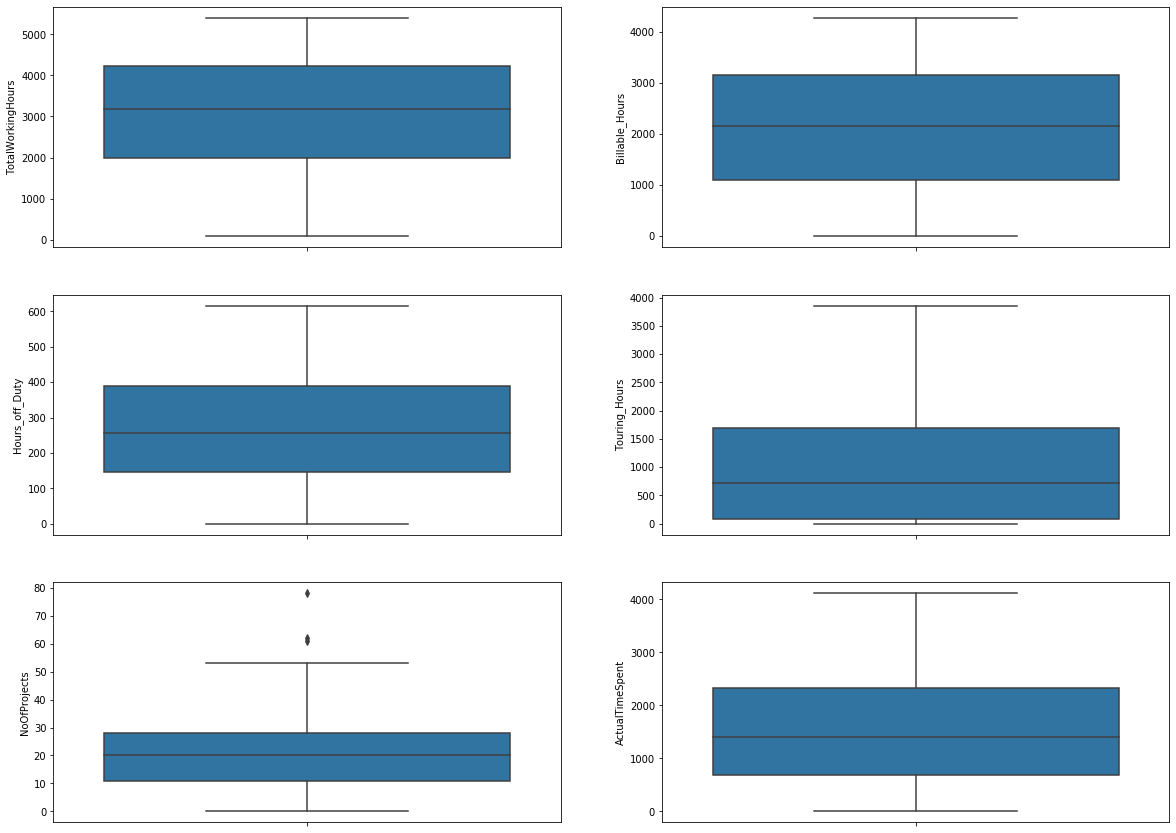

In [21]:
# Using boxplot to identify outliers

fig, axs = plt.subplots(3, 2, figsize=(20,15))

for col,ax in zip(num_columns, axs.flat):
    sns.boxplot(y=col, data=final_train_data, ax=ax)
    
plt.show()

## Univariate analysis of categorical columns

In [22]:
final_train_data.describe(include='category')

,Designation,Sex
count,245,245
unique,5,2
top,Junior,1
freq,79,216


In [23]:
final_train_data.dtypes

TotalWorkingHours     float64
Billable_Hours        float64
Hours_off_Duty        float64
Touring_Hours         float64
NoOfProjects            int64
ActualTimeSpent         int64
Designation          category
Sex                  category
Left_Company          float64
Job_History_Count       int64
dtype: object

In [24]:
for col in final_train_data.columns:
    if final_train_data[col].dtype.name == 'category':
        print("Column = ", col, "\n")
        print(final_train_data[col].value_counts())
        print("\n--------------------------------- \n")

Column =  Designation 

Junior    79
VP        63
Senior    63
EVP       28
MD        12
Name: Designation, dtype: int64

--------------------------------- 

Column =  Sex 

1    216
0     29
Name: Sex, dtype: int64

--------------------------------- 



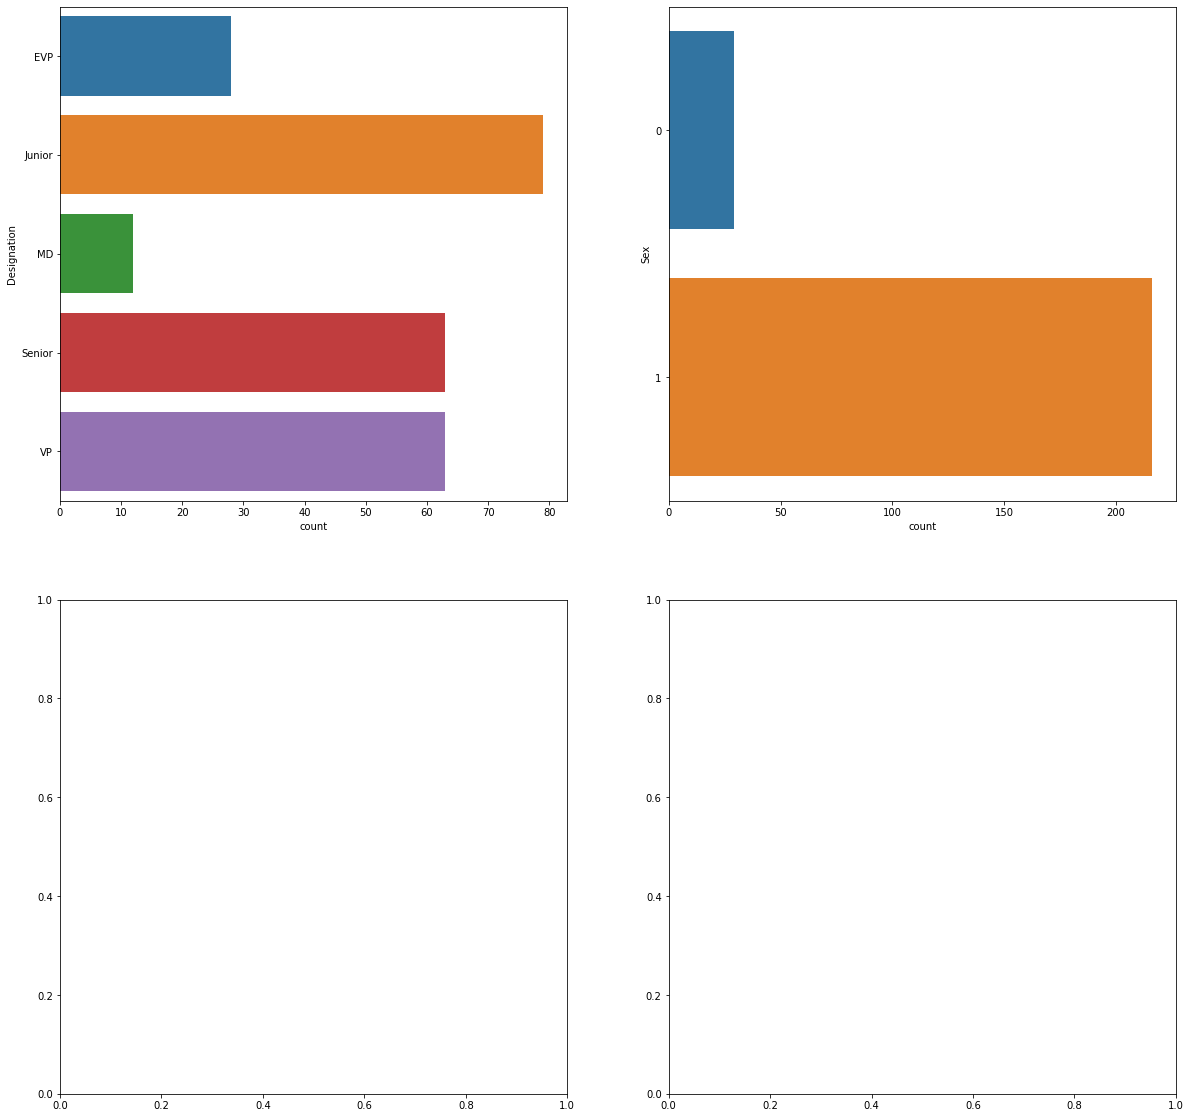

In [25]:
#Using countplot to view distribution of categorical feature levels
fig, axs = plt.subplots(2, 2, figsize=(20,20))

for col,ax in zip(cat_columns, axs.flat):
    sns.countplot(y=col, data=final_train_data[cat_columns], ax=ax)
    
plt.show()

## Data transformation

In [26]:
# Standardization of numerical attributes
#Import
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(final_train_data[num_columns])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [27]:
#Scale on train data
final_train_data[num_columns] = scaler.transform(final_train_data[num_columns])


In [28]:
#Scale on test data
final_test_data[num_columns] = scaler.transform(final_test_data[num_columns])

In [29]:
# Dummification of categorical attributes
final_train_data = pd.get_dummies(final_train_data, columns=cat_columns, drop_first=True)

# Test
final_test_data = pd.get_dummies(final_test_data, columns=cat_columns, drop_first=True)

In [30]:
final_train_data.head()
#final_test_data.head()
#final_train_data.shape

,TotalWorkingHours,Billable_Hours,Hours_off_Duty,Touring_Hours,NoOfProjects,ActualTimeSpent,Left_Company,Job_History_Count,Designation_Junior,Designation_MD,Designation_Senior,Designation_VP,Sex_1
0,0.263780,0.317918,0.999679,1.300594,1.728055,1.220933,0.0,0.159808,0,1,0,0,1
1,-0.768000,-0.718088,0.453025,-0.346105,-0.603917,-0.853143,1.0,0.858970,0,0,0,1,0
2,0.396936,1.026903,-0.257624,2.019340,0.200211,1.721572,0.0,-0.539353,0,0,1,0,1
3,0.762570,0.577356,-0.476286,-0.988606,-0.201853,0.388702,0.0,0.159808,0,0,1,0,1
4,0.530092,0.543346,0.562356,0.741776,-0.041027,0.668279,0.0,-1.238515,0,0,1,0,1


## Define x and y

In [31]:
X = final_train_data.loc[:, final_train_data.columns != 'Left_Company']
y = final_train_data['Left_Company']

In [32]:
X.dtypes

TotalWorkingHours     float64
Billable_Hours        float64
Hours_off_Duty        float64
Touring_Hours         float64
NoOfProjects          float64
ActualTimeSpent       float64
Job_History_Count     float64
Designation_Junior      uint8
Designation_MD          uint8
Designation_Senior      uint8
Designation_VP          uint8
Sex_1                   uint8
dtype: object

## Split data into training and validation data

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=123, 
                                                    stratify=y)

In [34]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(171, 12)
(74, 12)
(171,)
(74,)


## Build a Logistic Regression model

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [39]:
lrc = LogisticRegression()

lrc.fit(X_train,y_train)

y_pred_train_lrc = lrc.predict(X_train)
y_pred_test_lrc = lrc.predict(X_test)

In [45]:
train_pred = lrc.predict(X_train)
test_pred = lrc.predict(X_test)

print(lrc.score(X_train, y_train))
print(lrc.score(X_test, y_test))

#print(confusion_matrix(y_true=y_test, y_pred = y_pred_test_lrc, labels = ['no', 'yes']))

#confusion_matrix_test = confusion_matrix(y_true=y_test, y_pred=y_pred_test_lrc,labels = ['no', 'yes'])
#confusion_matrix_test

0.9707602339181286
0.9459459459459459


In [46]:
#Predicting on final test data
predicted_result =lrc.predict(final_test_data)

In [47]:
predicted_result

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [48]:
test_attrition['Left_Company'] = predicted_result

In [49]:
test_attrition.to_csv("GouraviGowda_B66_MiTH_LR.csv", index=False)

## Build SVM model

In [50]:
from sklearn.svm import SVC

In [51]:
## Use Grid Search for parameter tuning

from sklearn.model_selection import GridSearchCV

svc_grid = SVC()
 
param_grid = { 
                'C': [0.001, 0.01, 0.1, 1, 10, 100 ],
                'gamma': [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 
                'kernel':['linear', 'rbf', 'poly' ]
             }

svc_cv_grid = GridSearchCV(estimator = svc_grid, param_grid = param_grid, cv = 5)

In [52]:
## Fit the grid search model
%time svc_cv_grid.fit(X=X_train, y=y_train)

Wall time: 3.47 s


C:\Users\91916\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'kernel': ['linear', 'rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [53]:
# Get the best parameters
svc_cv_grid.best_params_

{'C': 1, 'gamma': 0, 'kernel': 'linear'}

In [54]:
## Predict
train_predictions = svc_cv_grid.predict(X_train)
test_predictions = svc_cv_grid.predict(X_test)

### Train data accuracy
from sklearn.metrics import accuracy_score,f1_score

print("TRAIN DATA ACCURACY",accuracy_score(y_train,train_predictions))
print("\nTrain data f1-score for class '0'",f1_score(y_train,train_predictions,pos_label=0))
print("\nTrain data f1-score for class '1'",f1_score(y_train,train_predictions,pos_label=1))

### Test data accuracy
print("\n\n--------------------------------------\n\n")
print("TEST DATA ACCURACY",accuracy_score(y_test,test_predictions))
print("\nTest data f1-score for class '0'",f1_score(y_test,test_predictions,pos_label=0))
print("\nTest data f1-score for class '1'",f1_score(y_test,test_predictions,pos_label=1))

TRAIN DATA ACCURACY 0.9824561403508771

Train data f1-score for class '0' 0.990228013029316

Train data f1-score for class '1' 0.9142857142857143


--------------------------------------


TEST DATA ACCURACY 0.9459459459459459

Test data f1-score for class '0' 0.9705882352941176

Test data f1-score for class '1' 0.6666666666666666


In [55]:
predicted_result =svc_cv_grid.predict(final_test_data)

In [56]:
predicted_result

array([0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [57]:
test_attrition['Left_Company'] = predicted_result

In [58]:
test_attrition.to_csv("GouraviGowda_B66_MiTH_SVM1.csv", index=False)

## Build a Random Forest classifier

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [60]:
clf = RandomForestClassifier(n_estimators=10,max_depth=8)
clf.fit(X=X_train, y=y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [61]:
y_pred = clf.predict(X_train)
print("Accuracy for Train set:")
print(accuracy_score(y_train,y_pred))

y_pred_test = clf.predict(X_test)
print("Accuracy for Test set:")
print(accuracy_score(y_test,y_pred_test))

print("\n")

print("Recall for Train set:")
print(recall_score(y_train,y_pred,pos_label=1))

print("Recall for Test set:")
print(recall_score(y_test,y_pred_test,pos_label=1))

print("\n")

print("Precision for Train set:")
print(precision_score(y_train,y_pred,pos_label=1))

print("Precision for Test set:")
print(precision_score(y_test,y_pred_test,pos_label=1))

Accuracy for Train set:
1.0
Accuracy for Test set:
0.9459459459459459


Recall for Train set:
1.0
Recall for Test set:
0.5


Precision for Train set:
1.0
Precision for Test set:
1.0


In [62]:
# Finding importances of features
clf.feature_importances_

array([0.03643943, 0.06440077, 0.08344511, 0.06965655, 0.03066285,
       0.09301244, 0.58494464, 0.01912144, 0.00345079, 0.00151589,
       0.0050012 , 0.00834889])

In [63]:
importances = clf.feature_importances_
indices = np.argsort(importances)
print(indices)

[ 9  8 10 11  7  4  0  1  3  2  5  6]


In [64]:
indices1 = np.argsort(importances)[::-1]
print(indices1)
pd.DataFrame([X_train.columns[indices1],np.sort(importances)[::-1]])

[ 6  5  2  3  1  0  4  7 11 10  8  9]


,0,1,2,3,4,5,6,7,8,9,10,11
0,Job_History_Count,ActualTimeSpent,Hours_off_Duty,Touring_Hours,Billable_Hours,TotalWorkingHours,NoOfProjects,Designation_Junior,Sex_1,Designation_VP,Designation_MD,Designation_Senior
1,0.584945,0.0930124,0.0834451,0.0696565,0.0644008,0.0364394,0.0306629,0.0191214,0.00834889,0.0050012,0.00345079,0.00151589


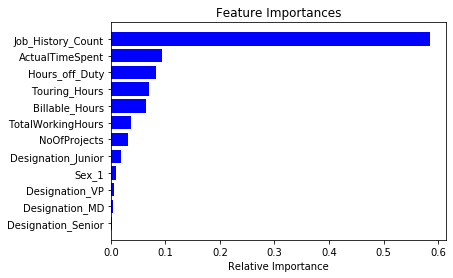

In [65]:
# Finding the relative importance of different features towards the target variable
import matplotlib.pyplot as plt
%matplotlib inline
features = X_train.columns

plt.title('Feature Importances')
plt.barh(range(len(indices)),importances[indices], color='b')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [66]:
# Hyper parameter tuning
rfc = RandomForestClassifier(n_jobs=-1, max_features='sqrt') 
 
# Use a grid over parameters of interest
param_grid = { 
           "n_estimators" : [9, 18, 27, 36, 45, 54, 63],
           "max_depth" : [2,3,5,7],
           "min_samples_leaf" : [2, 4]}

scores = ['precision', 'recall']

In [67]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print("\n")

    clf = GridSearchCV(estimator=rfc, param_grid=param_grid,cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on training set:")
    print("\n")
    print(clf.best_params_)
    print("\n")
    
    print("Grid scores on training set:")
    print("\n")
    means = clf.cv_results_['mean_test_score']
    for mean, params in zip(means, clf.cv_results_['params']):
        print("%0.3f for %r"
              % (mean, params))

# Tuning hyper-parameters for precision




C:\Users\91916\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on training set:


{'max_depth': 3, 'min_samples_leaf': 2, 'n_estimators': 18}


Grid scores on training set:


0.870 for {'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 9}
0.657 for {'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 18}
0.547 for {'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 27}
0.663 for {'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 36}
0.867 for {'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 45}
0.877 for {'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 54}
0.873 for {'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 63}
0.759 for {'max_depth': 2, 'min_samples_leaf': 4, 'n_estimators': 9}
0.765 for {'max_depth': 2, 'min_samples_leaf': 4, 'n_estimators': 18}
0.765 for {'max_depth': 2, 'min_samples_leaf': 4, 'n_estimators': 27}
0.864 for {'max_depth': 2, 'min_samples_leaf': 4, 'n_estimators': 36}
0.768 for {'max_depth': 2, 'min_samples_leaf': 4, 'n_estimators': 45}
0.771 for {'max_depth': 

C:\Users\91916\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on training set:


{'max_depth': 3, 'min_samples_leaf': 2, 'n_estimators': 63}


Grid scores on training set:


0.709 for {'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 9}
0.804 for {'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 18}
0.783 for {'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 27}
0.653 for {'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 36}
0.550 for {'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 45}
0.727 for {'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 54}
0.779 for {'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 63}
0.550 for {'max_depth': 2, 'min_samples_leaf': 4, 'n_estimators': 9}
0.550 for {'max_depth': 2, 'min_samples_leaf': 4, 'n_estimators': 18}
0.702 for {'max_depth': 2, 'min_samples_leaf': 4, 'n_estimators': 27}
0.526 for {'max_depth': 2, 'min_samples_leaf': 4, 'n_estimators': 36}
0.550 for {'max_depth': 2, 'min_samples_leaf': 4, 'n_estimators': 45}
0.601 for {'max_depth': 

In [68]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid,cv=5)
CV_rfc.fit(X=X_train, y=y_train)

C:\Users\91916\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='sqrt',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='

In [69]:
print(CV_rfc.best_score_, CV_rfc.best_params_)

0.9766081871345029 {'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 18}


In [70]:
y_pred_test=CV_rfc.predict(X_test)
print(accuracy_score(y_test,y_pred_test))

0.9459459459459459


In [71]:
predicted_result =CV_rfc.predict(final_test_data)

In [72]:
predicted_result

array([0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [73]:
test_attrition['Left_Company'] = predicted_result

In [74]:
test_attrition.to_csv("GouraviGowda_B66_MiTH_RandomForest.csv", index=False)